<a href="https://colab.research.google.com/github/SamudiniD/Efficient-Denoising-for-single-band-astronomical-images/blob/main/Baseline_U_Net_VS_Best_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Baseline U-Net Model

##Pipeline: training with timing, plotting loss curves, and per-image FITS evaluation on two images.

Epoch 1/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.1132 - val_loss: 0.0242 - learning_rate: 1.0000e-04
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0234 - val_loss: 0.0222 - learning_rate: 1.0000e-04
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0226 - val_loss: 0.0214 - learning_rate: 1.0000e-04
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0224 - val_loss: 0.0214 - learning_rate: 1.0000e-04
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0221 - val_loss: 0.0218 - learning_rate: 1.0000e-04
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0216 - val_loss: 0.0214 - learning_rate: 1.0000e-04
Epoch 7/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0220 - val_loss: 0.0217 - learning_rate: 1.0000e-04
Epoch 8/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0219 - val_loss: 0.0217 - learning_rate: 1.0000e-04
Epoch 9/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0216 - v

Training completed in 28.3s


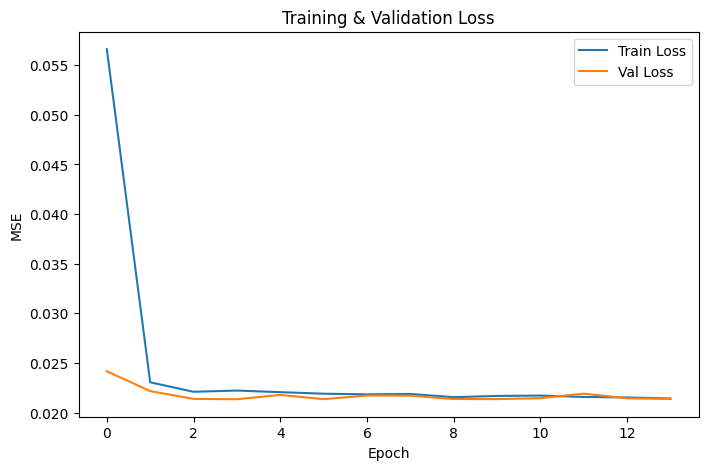

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


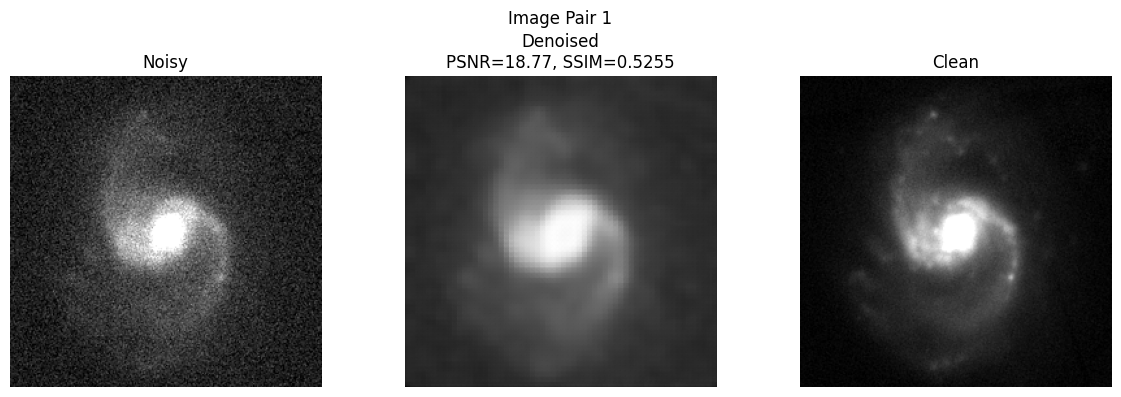

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


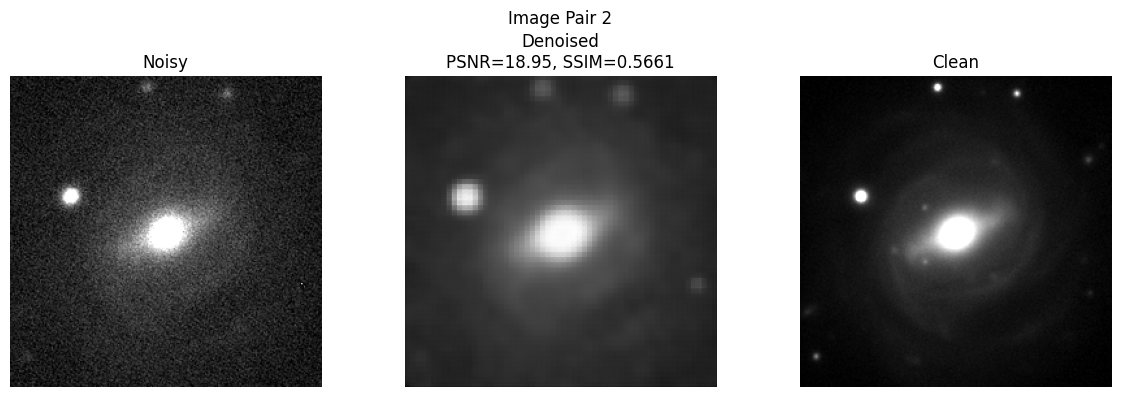

In [7]:
import numpy as np
import time
import matplotlib.pyplot as plt
from astropy.io import fits
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# -------------------------------
# 0. FITS Loading Utility
# -------------------------------
def load_fits_normalized(path, target_size=(240,240)):
    """Load a FITS file, clip to 1–99th percentiles, normalize to [0,1], resize."""
    with fits.open(path) as hdul:
        data = hdul[0].data.astype(np.float32)
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    p1, p99 = np.percentile(data, (1, 99))
    data = np.clip(data, p1, p99)
    data = (data - p1) / (p99 - p1 + 1e-8)
    # resize and drop channel dim
    data = tf.image.resize(data[..., np.newaxis], target_size).numpy().squeeze()
    return data

# -------------------------------
# 1. Dataset Loading & Data Augmentation
# -------------------------------
def load_dataset():
    """Load noisy and clean numpy arrays from the train folder."""
    base = "/content/drive/MyDrive/SDSS_augmented_npy/train/"
    X = np.load(base + "noisy.npy").astype(np.float32)
    Y = np.load(base + "clean.npy").astype(np.float32)
    X = np.clip(X, 0, 1)
    Y = np.clip(Y, 0, 1)
    # ensure channel dim
    if X.ndim == 3:
        X = X[..., np.newaxis]
        Y = Y[..., np.newaxis]
    return X, Y

def add_gaussian_noise(image, std=0.05):
    """Add Gaussian noise."""
    return np.clip(image + np.random.normal(0, std, image.shape), 0.0, 1.0)

def add_salt_and_pepper(image, salt_prob=0.01, pepper_prob=0.01):
    """Add salt-and-pepper noise."""
    noisy = image.copy()
    total = image.shape[0]*image.shape[1]
    # salt
    coords = [np.random.randint(0, i, int(total*salt_prob)) for i in image.shape[:2]]
    noisy[coords[0], coords[1], 0] = 1.0
    # pepper
    coords = [np.random.randint(0, i, int(total*pepper_prob)) for i in image.shape[:2]]
    noisy[coords[0], coords[1], 0] = 0.0
    return noisy

def add_mixed_noise(image):
    """Randomly apply Gaussian or salt-and-pepper noise."""
    return add_gaussian_noise(image) if np.random.rand() < 0.5 else add_salt_and_pepper(image)

def augment_data(X, Y):
    """Augment both inputs and targets (for consistency, though targets stay clean if you prefer)."""
    X_aug = np.array([add_mixed_noise(img) for img in X])
    Y_aug = Y.copy()  # keep targets clean
    return X_aug, Y_aug

# -------------------------------
# 2. Plain U-Net (Encoder–Decoder) Baseline
# -------------------------------
def build_plain_unet(input_shape=(240,240,1), nf=64):
    """
    A simple encoder–decoder without skip connections:
      - down: Conv → Pool → Conv → Pool → Conv
      - up:   Transpose → Transpose → Conv
    """
    inp = layers.Input(input_shape)
    # Encoding
    x = layers.Conv2D(nf,   3, padding='same', activation='relu')(inp)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(nf*2, 3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(nf*4, 3, padding='same', activation='relu')(x)
    # Decoding
    x = layers.Conv2DTranspose(nf*2, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(nf,   3, strides=2, padding='same', activation='relu')(x)
    out = layers.Conv2D(1, 3, padding='same')(x)
    return models.Model(inp, out)

# -------------------------------
# 3. Training & Loss Curve Plotting
# -------------------------------
# Load and augment
X, Y = load_dataset()
X_aug, Y_aug = augment_data(X, Y)

# Build and compile
model = build_plain_unet()
model.compile(optimizer=optimizers.Adam(1e-4), loss='mse')

# Callbacks
callbacks = [
    EarlyStopping('val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau('val_loss', patience=5, factor=0.5)
]

# Train with timing
start_time = time.time()
history = model.fit(
    X_aug, Y_aug,
    epochs=100,
    batch_size=8,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)
train_time = time.time() - start_time
print(f"Training completed in {train_time:.1f}s")

# Save model
model.save("/content/drive/MyDrive/PS1_Models/plain_unet_baseline.h5")

# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# -------------------------------
# 4. Evaluation on Two FITS Images
# -------------------------------
fits_pairs = [
    ("/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_004_noisy.fits",
     "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_004_clean.fits"),
    ("/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_005_noisy.fits",
     "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_005_clean.fits")
]

for idx, (noisy_path, clean_path) in enumerate(fits_pairs, 1):
    noisy = load_fits_normalized(noisy_path)
    clean = load_fits_normalized(clean_path)
    inp = noisy[np.newaxis, ..., np.newaxis]
    den = model.predict(inp)[0, ..., 0]
    psnr = peak_signal_noise_ratio(clean, den, data_range=1.0)
    ssim = structural_similarity(clean, den, data_range=1.0)

    plt.figure(figsize=(12,4))
    for i, (img, title) in enumerate([
        (noisy, 'Noisy'),
        (den,   f'Denoised\nPSNR={psnr:.2f}, SSIM={ssim:.4f}'),
        (clean, 'Clean')
    ]):
        ax = plt.subplot(1,3,i+1)
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f"Image Pair {idx}")
    plt.tight_layout()
    plt.show()


In [ ]:
# -------------------------------
# 3‑bis.  PSNR / SSIM distribution on full training set
#           (insert right after the loss‑curve plot)
# -------------------------------
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity   as ssim_metric

print("\nComputing PSNR / SSIM distributions …")
t0 = time.time()

# Forward‑pass (no augmentation, original X / Y)
preds = model.predict(X, batch_size=32)          # shape: (N,240,240,1)

psnr_vals = [psnr_metric(Y[i, ..., 0], preds[i, ..., 0], data_range=1.0)
             for i in range(len(X))]
ssim_vals = [ssim_metric(Y[i, ..., 0], preds[i, ..., 0], data_range=1.0)
             for i in range(len(X))]

t_inf = time.time() - t0
print(f"Inference on {len(X)} images: {t_inf:.2f} s  "
      f"({t_inf/len(X):.3f} s/image)")
print(f"PSNR  mean ± std: {np.mean(psnr_vals):.2f} ± {np.std(psnr_vals):.2f}")
print(f"SSIM  mean ± std: {np.mean(ssim_vals):.4f} ± {np.std(ssim_vals):.4f}")

# Histograms
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(psnr_vals, bins=30, color='steelblue')
plt.title('PSNR distribution'); plt.xlabel('PSNR (dB)'); plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(ssim_vals, bins=30, color='seagreen')
plt.title('SSIM distribution'); plt.xlabel('SSIM'); plt.ylabel('Count')

plt.tight_layout(); plt.show()


#Best U-Net Model
## Pipeline: training with timing, plotting loss curves, and per-image FITS evaluation on two images.

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 611ms/step - loss: 0.1233 - val_loss: 0.0229 - learning_rate: 1.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0230 - val_loss: 0.0217 - learning_rate: 1.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0223 - val_loss: 0.0217 - learning_rate: 1.0000e-04
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0222 - val_loss: 0.0215 - learning_rate: 1.0000e-04
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0216 - val_loss: 0.0215 - learning_rate: 1.0000e-04
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0225 - val_loss: 0.0216 - learning_rate: 1.0000e-04
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0221 - val_loss: 0.0215 - learning_rate: 1.0000e-04
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0216 - val_loss: 0.0220 - learning_rate: 1.0000e-04
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0214 - val_loss: 0.0222 

Training completed in 240.6s


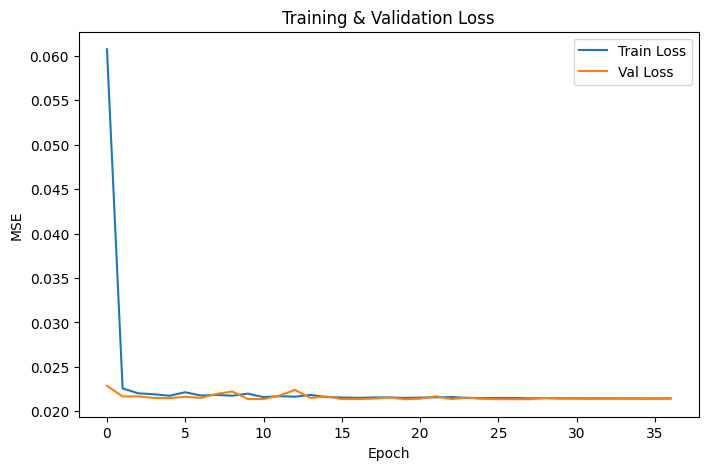

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


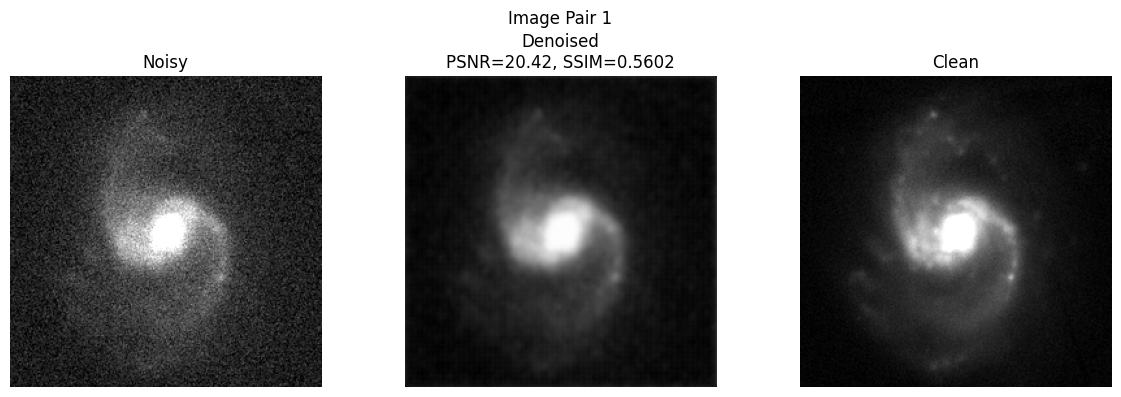

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


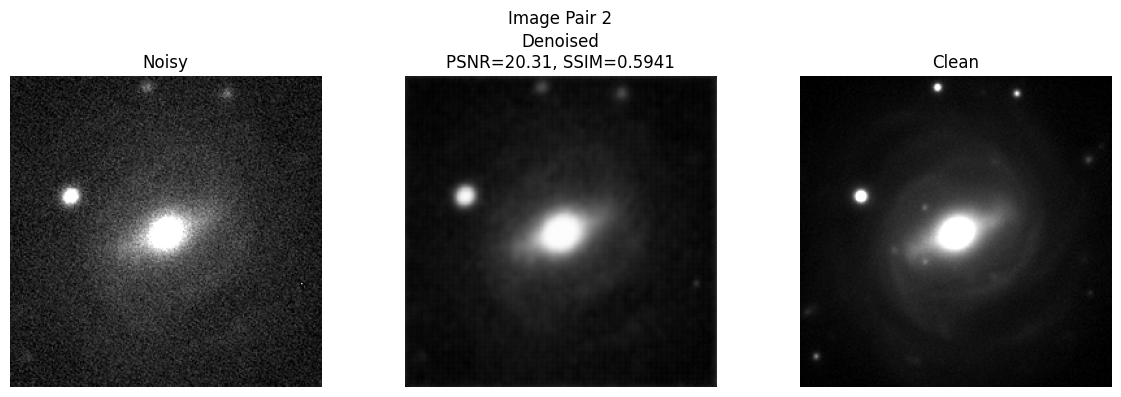

In [4]:


import numpy as np
import time
import matplotlib.pyplot as plt
from astropy.io import fits
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# -------------------------------
# 0. FITS Loading Utility
# -------------------------------
def load_fits_normalized(path, target_size=(240,240)):
    """Load a FITS file, clip to 1–99th percentiles, normalize to [0,1], resize."""
    with fits.open(path) as hdul:
        data = hdul[0].data.astype(np.float32)
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    p1, p99 = np.percentile(data, (1, 99))
    data = np.clip(data, p1, p99)
    data = (data - p1) / (p99 - p1 + 1e-8)
    # resize and drop channel dim
    data = tf.image.resize(data[..., np.newaxis], target_size).numpy().squeeze()
    return data

# -------------------------------
# 1. Dataset Loading & Data Augmentation
# -------------------------------
def load_dataset():
    """Load noisy and clean numpy arrays from the train folder."""
    base = "/content/drive/MyDrive/SDSS_augmented_npy/train/"
    X = np.load(base + "noisy.npy").astype(np.float32)
    Y = np.load(base + "clean.npy").astype(np.float32)
    X = np.clip(X, 0, 1)
    Y = np.clip(Y, 0, 1)
    # ensure channel dim
    if X.ndim == 3:
        X = X[..., np.newaxis]
        Y = Y[..., np.newaxis]
    return X, Y

def add_gaussian_noise(image, std=0.05):
    """Add Gaussian noise."""
    return np.clip(image + np.random.normal(0, std, image.shape), 0.0, 1.0)

def add_salt_and_pepper(image, salt_prob=0.01, pepper_prob=0.01):
    """Add salt-and-pepper noise."""
    noisy = image.copy()
    total = image.shape[0]*image.shape[1]
    # salt
    coords = [np.random.randint(0, i, int(total*salt_prob)) for i in image.shape[:2]]
    noisy[coords[0], coords[1], 0] = 1.0
    # pepper
    coords = [np.random.randint(0, i, int(total*pepper_prob)) for i in image.shape[:2]]
    noisy[coords[0], coords[1], 0] = 0.0
    return noisy

def add_mixed_noise(image):
    """Randomly apply Gaussian or salt-and-pepper noise."""
    return add_gaussian_noise(image) if np.random.rand() < 0.5 else add_salt_and_pepper(image)

def augment_data(X, Y):
    """Augment both inputs and targets (for consistency, though targets stay clean if you prefer)."""
    X_aug = np.array([add_mixed_noise(img) for img in X])
    Y_aug = Y.copy()  # keep targets clean
    return X_aug, Y_aug

# -------------------------------
# 2. Attention‑U‑Net (skip‑connections + self‑attention)
# -------------------------------

class MultiHeadSelfAttention(layers.Layer):
    """
    Simple MHSA block for 2‑D feature maps.
    Splits channels into heads ⇒ Q,K,V ⇒ softmax(QKᵀ/√d) V
    """
    def __init__(self, num_heads=4, key_dim=32):
        super().__init__()
        self.mhsa = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=key_dim,      # d_k per head
            attention_axes=(1, 2) # spatial axes (H, W)
        )
        self.norm  = layers.LayerNormalization()

    def call(self, x):
        # (B,H,W,C) → (B,H*W,C) inside attention → (B,H,W,C) out
        attn = self.mhsa(x, x)
        return self.norm(x + attn)            # residual + norm


def conv_block(x, filters, name):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu', name=name+'_c1')(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu', name=name+'_c2')(x)
    return x


def build_attention_unet(input_shape=(240, 240, 1), nf=64,
                         num_heads=4, key_dim=32):
    """
    U‑Net backbone + MHSA bottleneck.
    Encoder: 3 levels.  Decoder: 3 levels with concatenated skips.
    """
    inputs = layers.Input(input_shape)

    # ---------- Encoder ----------
    c1 = conv_block(inputs, nf,   'enc1')
    p1 = layers.MaxPool2D(name='pool1')(c1)

    c2 = conv_block(p1,     nf*2, 'enc2')
    p2 = layers.MaxPool2D(name='pool2')(c2)

    c3 = conv_block(p2,     nf*4, 'enc3')
    p3 = layers.MaxPool2D(name='pool3')(c3)

    # ---------- Bottleneck + Attention ----------
    bn  = conv_block(p3, nf*8, 'bottleneck_pre')
    bn  = MultiHeadSelfAttention(num_heads, key_dim)(bn)
    bn  = conv_block(bn, nf*8, 'bottleneck_post')

    # ---------- Decoder ----------
    u3  = layers.Conv2DTranspose(nf*4, 3, strides=2,
                                 padding='same', activation='relu', name='up3')(bn)
    u3  = layers.Concatenate(name='concat3')([u3, c3])
    c4  = conv_block(u3, nf*4, 'dec3')

    u2  = layers.Conv2DTranspose(nf*2, 3, strides=2,
                                 padding='same', activation='relu', name='up2')(c4)
    u2  = layers.Concatenate(name='concat2')([u2, c2])
    c5  = conv_block(u2, nf*2, 'dec2')

    u1  = layers.Conv2DTranspose(nf,   3, strides=2,
                                 padding='same', activation='relu', name='up1')(c5)
    u1  = layers.Concatenate(name='concat1')([u1, c1])
    c6  = conv_block(u1, nf,   'dec1')

    outputs = layers.Conv2D(1, 1, activation=None, name='out')(c6)
    return models.Model(inputs, outputs, name='AttentionUNet')

# -------------------------------
# 3. Training & Loss Curve Plotting
# -------------------------------
# Load and augment
X, Y = load_dataset()
X_aug, Y_aug = augment_data(X, Y)

# Build and compile
model = build_attention_unet()      # instead of build_plain_unet()
model.compile(optimizer=optimizers.Adam(1e-4), loss='mse')


# Callbacks
callbacks = [
    EarlyStopping('val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau('val_loss', patience=5, factor=0.5)
]

# Train with timing
start_time = time.time()
history = model.fit(
    X_aug, Y_aug,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)
train_time = time.time() - start_time
print(f"Training completed in {train_time:.1f}s")

# Save model
model.save("/content/drive/MyDrive/PS1_Models/best_unet_baseline.h5")

# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# -------------------------------
# 4. Evaluation on Two FITS Images
# -------------------------------
fits_pairs = [
    ("/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_004_noisy.fits",
     "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_004_clean.fits"),
    ("/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_005_noisy.fits",
     "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_005_clean.fits")
]

for idx, (noisy_path, clean_path) in enumerate(fits_pairs, 1):
    noisy = load_fits_normalized(noisy_path)
    clean = load_fits_normalized(clean_path)
    inp = noisy[np.newaxis, ..., np.newaxis]
    den = model.predict(inp)[0, ..., 0]
    psnr = peak_signal_noise_ratio(clean, den, data_range=1.0)
    ssim = structural_similarity(clean, den, data_range=1.0)

    plt.figure(figsize=(12,4))
    for i, (img, title) in enumerate([
        (noisy, 'Noisy'),
        (den,   f'Denoised\nPSNR={psnr:.2f}, SSIM={ssim:.4f}'),
        (clean, 'Clean')
    ]):
        ax = plt.subplot(1,3,i+1)
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f"Image Pair {idx}")
    plt.tight_layout()
    plt.show()


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 252ms/step - loss: 0.1040 - val_loss: 0.0231 - learning_rate: 1.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0238 - val_loss: 0.0215 - learning_rate: 1.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0216 - val_loss: 0.0220 - learning_rate: 1.0000e-04
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0221 - val_loss: 0.0214 - learning_rate: 1.0000e-04
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0226 - val_loss: 0.0227 - learning_rate: 1.0000e-04
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0220 - val_loss: 0.0215 - learning_rate: 1.0000e-04
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0220 - val_loss: 0.0213 - learning_rate: 1.0000e-04
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0214 - val_loss: 0.0219 - learning_rate: 1.0000e-04
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0214 - val_loss: 0.0216 

Training time: 190.6 s


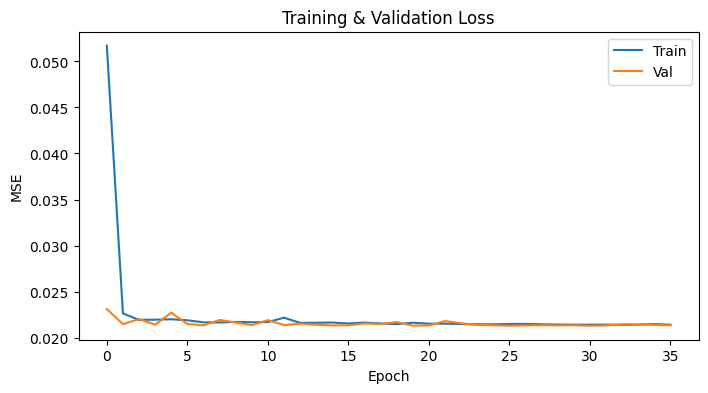

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 284ms/step


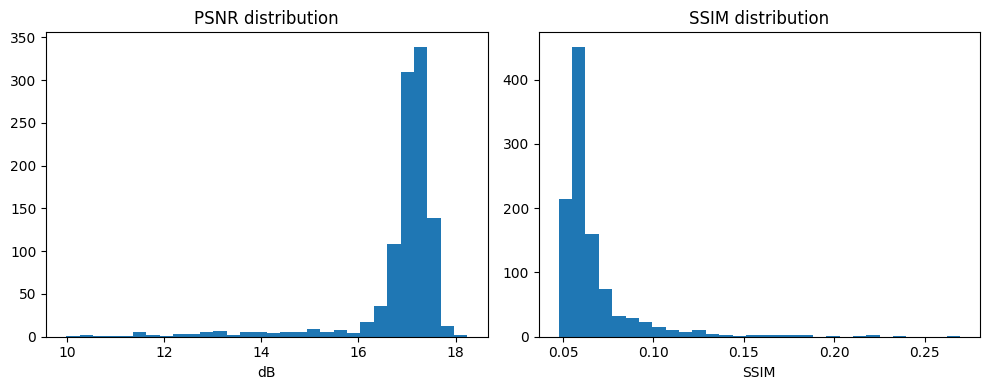

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


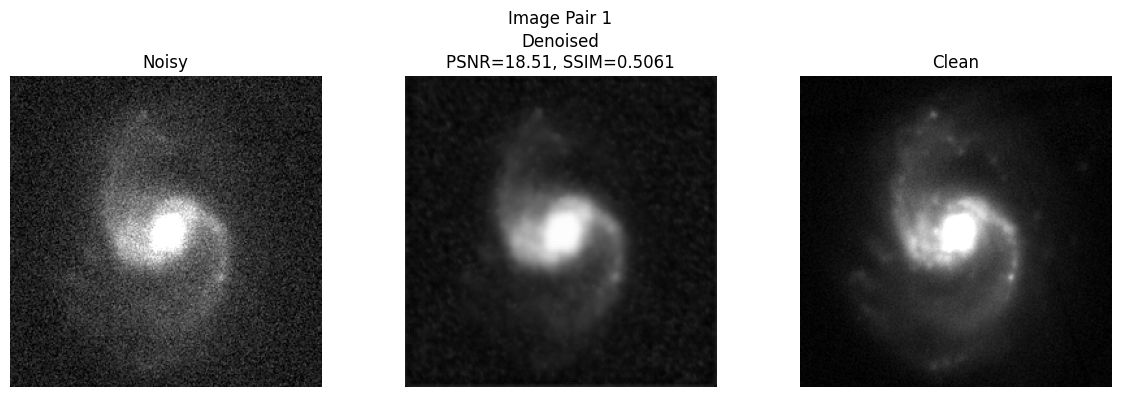

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


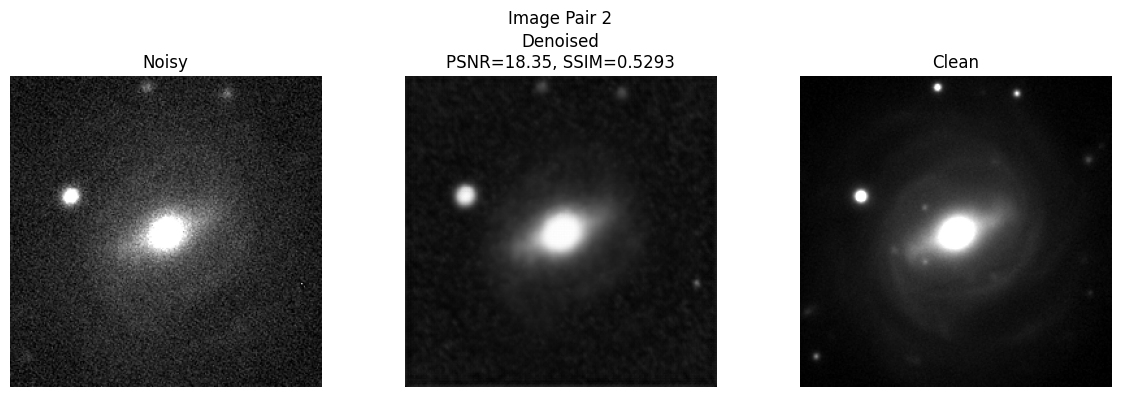


──── Runtime summary ────
Model build/compile :   0.21 s
Training            : 190.56 s
Inference (train)   :  14.79 s (0.014 s/img)
Inference (2 FITS)  :   1.93 s (0.967 s/img)
Total script        : 208.40 s
────────────────────────


In [11]:
# ------------------------------- 3. Training, Timing, PSNR/SSIM Distributions -------------------------------

import time
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity   as ssim_metric

# ── 3.1 Timers ──────────────────────────────────────────────────────────────
t_script = time.perf_counter()             # total‑script timer

# Data already loaded / augmented above
t_data = 0.0  # (load_dataset + augment ran before timing; set manually if needed)

# ── 3.2 Build & compile timer ───────────────────────────────────────────────
t0 = time.perf_counter()
model = build_attention_unet()
model.compile(optimizers.Adam(1e-4), loss='mse')
t_build = time.perf_counter() - t0

# ── 3.3 Training timer ──────────────────────────────────────────────────────
callbacks = [
    EarlyStopping('val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau('val_loss', patience=5, factor=0.5)
]
t0 = time.perf_counter()
history = model.fit(
    X_aug, Y_aug,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)
t_train = time.perf_counter() - t0
print(f"Training time: {t_train:.1f} s")

model.save("/content/drive/MyDrive/PS1_Models/best_unet_baseline.h5")

# ── 3.4 Loss curve ──────────────────────────────────────────────────────────
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Training & Validation Loss'); plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.legend(); plt.show()

# ── 3.5 Inference on full set → PSNR & SSIM distributions ───────────────────
t0 = time.perf_counter()
preds = model.predict(X_aug, batch_size=32)[..., 0]       # (N,H,W)
psnr_vals = [psnr_metric(Y_aug[i, ..., 0], preds[i], data_range=1.)
             for i in range(len(X_aug))]
ssim_vals = [ssim_metric(Y_aug[i, ..., 0], preds[i], data_range=1.)
             for i in range(len(X_aug))]
t_inf_train = time.perf_counter() - t0

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.hist(psnr_vals, bins=30); plt.title('PSNR distribution'); plt.xlabel('dB')
plt.subplot(1,2,2); plt.hist(ssim_vals, bins=30); plt.title('SSIM distribution'); plt.xlabel('SSIM')
plt.tight_layout(); plt.show()

# ------------------------------- 4. Two‑FITS qualitative demo (unchanged) -------------------------------

fits_pairs = [
    ("/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_004_noisy.fits",
     "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_004_clean.fits"),
    ("/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_005_noisy.fits",
     "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_005_clean.fits")
]

t0 = time.perf_counter()
for idx, (noisy_path, clean_path) in enumerate(fits_pairs, 1):
    noisy = load_fits_normalized(noisy_path)
    clean = load_fits_normalized(clean_path)
    den   = model.predict(noisy[None, ..., None])[0, ..., 0]
    psnr  = psnr_metric(clean, den, data_range=1.0)
    ssim  = ssim_metric(clean, den, data_range=1.0)

    plt.figure(figsize=(12,4))
    for j,(img,title) in enumerate([
        (noisy, 'Noisy'),
        (den,   f'Denoised\nPSNR={psnr:.2f}, SSIM={ssim:.4f}'),
        (clean, 'Clean')]):
        ax = plt.subplot(1,3,j+1); ax.imshow(img, cmap='gray')
        ax.set_title(title); ax.axis('off')
    plt.suptitle(f'Image Pair {idx}'); plt.tight_layout(); plt.show()
t_inf_fits = time.perf_counter() - t0

# ------------------------------- 5. Runtime summary -------------------------------

t_total = time.perf_counter() - t_script
print("\n──── Runtime summary ────")
print(f"Model build/compile : {t_build:6.2f} s")
print(f"Training            : {t_train:6.2f} s")
print(f"Inference (train)   : {t_inf_train:6.2f} s "
      f"({t_inf_train/len(X_aug):.3f} s/img)")
print(f"Inference (2 FITS)  : {t_inf_fits:6.2f} s "
      f"({t_inf_fits/2:.3f} s/img)")
print(f"Total script        : {t_total:6.2f} s")
print("────────────────────────")


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - loss: 0.1893 - val_loss: 0.0327 - learning_rate: 1.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.0300 - val_loss: 0.0242 - learning_rate: 1.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.0241 - val_loss: 0.0223 - learning_rate: 1.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 0.0227 - val_loss: 0.0227 - learning_rate: 1.0000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.0220 - val_loss: 0.0215 - learning_rate: 1.0000e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.0217 - val_loss: 0.0216 - learning_rate: 1.0000e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.0219 - val_loss: 0.0215 - learning_rate: 1.0000e-04
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.0221 - val_loss: 0.0214 - learning_rate: 1.0000e-04
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.0220 - val_loss: 0.

Training completed in 206.9s


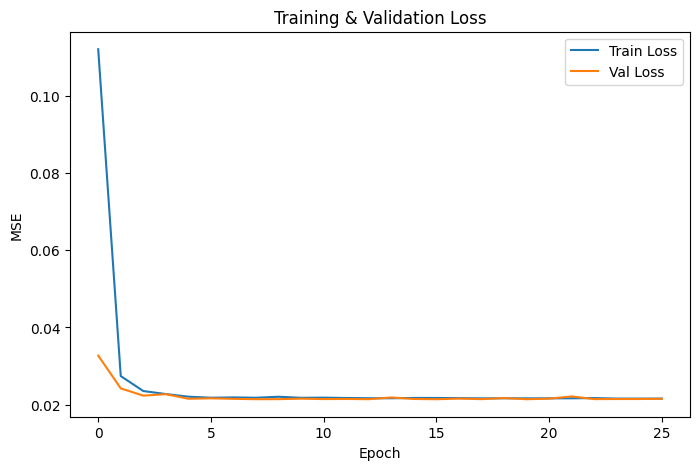

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


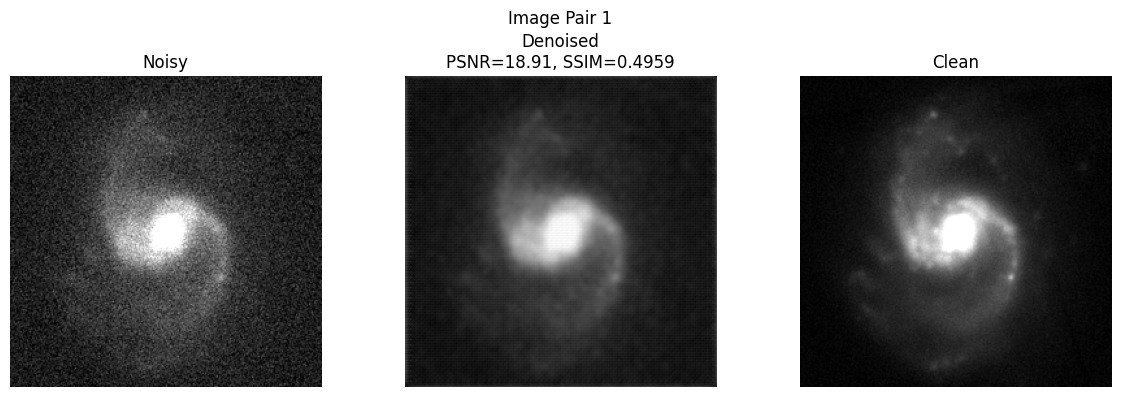

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


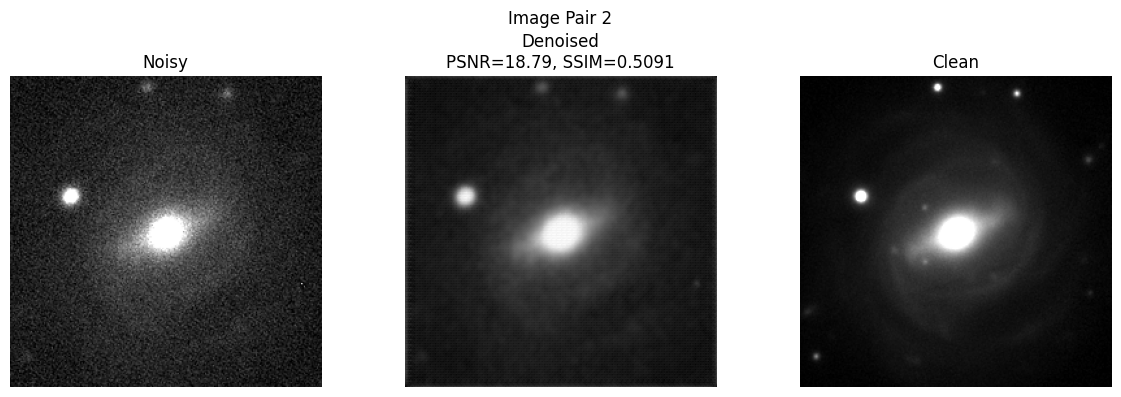

In [8]:
# # train_and_evaluate.py
# # Pipeline: training with timing, plotting loss curves, and per-image FITS evaluation on two images.---- 32 batch size

# import numpy as np
# import time
# import matplotlib.pyplot as plt
# from astropy.io import fits
# import tensorflow as tf
# from tensorflow.keras import layers, models, optimizers
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# # -------------------------------
# # 0. FITS Loading Utility
# # -------------------------------
# def load_fits_normalized(path, target_size=(240,240)):
#     """Load a FITS file, clip to 1–99th percentiles, normalize to [0,1], resize."""
#     with fits.open(path) as hdul:
#         data = hdul[0].data.astype(np.float32)
#     data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
#     p1, p99 = np.percentile(data, (1, 99))
#     data = np.clip(data, p1, p99)
#     data = (data - p1) / (p99 - p1 + 1e-8)
#     # resize and drop channel dim
#     data = tf.image.resize(data[..., np.newaxis], target_size).numpy().squeeze()
#     return data

# # -------------------------------
# # 1. Dataset Loading & Data Augmentation
# # -------------------------------
# def load_dataset():
#     """Load noisy and clean numpy arrays from the train folder."""
#     base = "/content/drive/MyDrive/SDSS_augmented_npy/train/"
#     X = np.load(base + "noisy.npy").astype(np.float32)
#     Y = np.load(base + "clean.npy").astype(np.float32)
#     X = np.clip(X, 0, 1)
#     Y = np.clip(Y, 0, 1)
#     # ensure channel dim
#     if X.ndim == 3:
#         X = X[..., np.newaxis]
#         Y = Y[..., np.newaxis]
#     return X, Y

# def add_gaussian_noise(image, std=0.05):
#     """Add Gaussian noise."""
#     return np.clip(image + np.random.normal(0, std, image.shape), 0.0, 1.0)

# def add_salt_and_pepper(image, salt_prob=0.01, pepper_prob=0.01):
#     """Add salt-and-pepper noise."""
#     noisy = image.copy()
#     total = image.shape[0]*image.shape[1]
#     # salt
#     coords = [np.random.randint(0, i, int(total*salt_prob)) for i in image.shape[:2]]
#     noisy[coords[0], coords[1], 0] = 1.0
#     # pepper
#     coords = [np.random.randint(0, i, int(total*pepper_prob)) for i in image.shape[:2]]
#     noisy[coords[0], coords[1], 0] = 0.0
#     return noisy

# def add_mixed_noise(image):
#     """Randomly apply Gaussian or salt-and-pepper noise."""
#     return add_gaussian_noise(image) if np.random.rand() < 0.5 else add_salt_and_pepper(image)

# def augment_data(X, Y):
#     """Augment both inputs and targets (for consistency, though targets stay clean if you prefer)."""
#     X_aug = np.array([add_mixed_noise(img) for img in X])
#     Y_aug = Y.copy()  # keep targets clean
#     return X_aug, Y_aug

# # -------------------------------
# # 2. Attention‑U‑Net (skip‑connections + self‑attention)
# # -------------------------------

# class MultiHeadSelfAttention(layers.Layer):
#     """
#     Simple MHSA block for 2‑D feature maps.
#     Splits channels into heads ⇒ Q,K,V ⇒ softmax(QKᵀ/√d) V
#     """
#     def __init__(self, num_heads=4, key_dim=32):
#         super().__init__()
#         self.mhsa = layers.MultiHeadAttention(
#             num_heads=num_heads,
#             key_dim=key_dim,      # d_k per head
#             attention_axes=(1, 2) # spatial axes (H, W)
#         )
#         self.norm  = layers.LayerNormalization()

#     def call(self, x):
#         # (B,H,W,C) → (B,H*W,C) inside attention → (B,H,W,C) out
#         attn = self.mhsa(x, x)
#         return self.norm(x + attn)            # residual + norm


# def conv_block(x, filters, name):
#     x = layers.Conv2D(filters, 3, padding='same', activation='relu', name=name+'_c1')(x)
#     x = layers.Conv2D(filters, 3, padding='same', activation='relu', name=name+'_c2')(x)
#     return x


# def build_attention_unet(input_shape=(240, 240, 1), nf=64,
#                          num_heads=4, key_dim=32):
#     """
#     U‑Net backbone + MHSA bottleneck.
#     Encoder: 3 levels.  Decoder: 3 levels with concatenated skips.
#     """
#     inputs = layers.Input(input_shape)

#     # ---------- Encoder ----------
#     c1 = conv_block(inputs, nf,   'enc1')
#     p1 = layers.MaxPool2D(name='pool1')(c1)

#     c2 = conv_block(p1,     nf*2, 'enc2')
#     p2 = layers.MaxPool2D(name='pool2')(c2)

#     c3 = conv_block(p2,     nf*4, 'enc3')
#     p3 = layers.MaxPool2D(name='pool3')(c3)

#     # ---------- Bottleneck + Attention ----------
#     bn  = conv_block(p3, nf*8, 'bottleneck_pre')
#     bn  = MultiHeadSelfAttention(num_heads, key_dim)(bn)
#     bn  = conv_block(bn, nf*8, 'bottleneck_post')

#     # ---------- Decoder ----------
#     u3  = layers.Conv2DTranspose(nf*4, 3, strides=2,
#                                  padding='same', activation='relu', name='up3')(bn)
#     u3  = layers.Concatenate(name='concat3')([u3, c3])
#     c4  = conv_block(u3, nf*4, 'dec3')

#     u2  = layers.Conv2DTranspose(nf*2, 3, strides=2,
#                                  padding='same', activation='relu', name='up2')(c4)
#     u2  = layers.Concatenate(name='concat2')([u2, c2])
#     c5  = conv_block(u2, nf*2, 'dec2')

#     u1  = layers.Conv2DTranspose(nf,   3, strides=2,
#                                  padding='same', activation='relu', name='up1')(c5)
#     u1  = layers.Concatenate(name='concat1')([u1, c1])
#     c6  = conv_block(u1, nf,   'dec1')

#     outputs = layers.Conv2D(1, 1, activation=None, name='out')(c6)
#     return models.Model(inputs, outputs, name='AttentionUNet')

# # -------------------------------
# # 3. Training & Loss Curve Plotting
# # -------------------------------
# # Load and augment
# X, Y = load_dataset()
# X_aug, Y_aug = augment_data(X, Y)

# # Build and compile
# model = build_attention_unet()      # instead of build_plain_unet()
# model.compile(optimizer=optimizers.Adam(1e-4), loss='mse')


# # Callbacks
# callbacks = [
#     EarlyStopping('val_loss', patience=10, restore_best_weights=True),
#     ReduceLROnPlateau('val_loss', patience=5, factor=0.5)
# ]

# # Train with timing
# start_time = time.time()
# history = model.fit(
#     X_aug, Y_aug,
#     epochs=100,
#     batch_size=32,
#     validation_split=0.1,
#     callbacks=callbacks,
#     verbose=1
# )
# train_time = time.time() - start_time
# print(f"Training completed in {train_time:.1f}s")

# # Save model
# model.save("/content/drive/MyDrive/PS1_Models/enhanced_unet_baseline.h5")

# # Plot loss curve
# plt.figure(figsize=(8,5))
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.title('Training & Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.legend()
# plt.show()

# # -------------------------------
# # 4. Evaluation on Two FITS Images
# # -------------------------------
# fits_pairs = [
#     ("/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_004_noisy.fits",
#      "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_004_clean.fits"),
#     ("/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_005_noisy.fits",
#      "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_005_clean.fits")
# ]

# for idx, (noisy_path, clean_path) in enumerate(fits_pairs, 1):
#     noisy = load_fits_normalized(noisy_path)
#     clean = load_fits_normalized(clean_path)
#     inp = noisy[np.newaxis, ..., np.newaxis]
#     den = model.predict(inp)[0, ..., 0]
#     psnr = peak_signal_noise_ratio(clean, den, data_range=1.0)
#     ssim = structural_similarity(clean, den, data_range=1.0)

#     plt.figure(figsize=(12,4))
#     for i, (img, title) in enumerate([
#         (noisy, 'Noisy'),
#         (den,   f'Denoised\nPSNR={psnr:.2f}, SSIM={ssim:.4f}'),
#         (clean, 'Clean')
#     ]):
#         ax = plt.subplot(1,3,i+1)
#         ax.imshow(img, cmap='gray')
#         ax.set_title(title)
#         ax.axis('off')
#     plt.suptitle(f"Image Pair {idx}")
#     plt.tight_layout()
#     plt.show()
